 <h2>Imports</h2>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import itertools
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, ShuffleSplit, learning_curve
from sklearn.metrics import mean_squared_error

/Users/yassinetahiri/anaconda2/envs/tensorflow35/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
DATA_PATH = '../Data/'

In [4]:
df_merchants = pd.read_csv(DATA_PATH + 'merchants.csv')
df_hist = pd.read_csv(DATA_PATH + 'historical_transactions.csv')
df_new = pd.read_csv(DATA_PATH + 'new_merchant_transactions.csv')
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')
df_sample_sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')

<h2>Utils functions</h2>

In [3]:
def evaluate_model(model, param_grid, X_train, X_test, y_train, y_test):

    cv_sets = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    scoring = 'neg_mean_squared_error'
    ylim=(-100.0, 5)

    grid_srch = GridSearchCV(model, param_grid=param_grid, cv=cv_sets, scoring=scoring)
    grid_srch.fit(X_train, y_train)

    # Best model
    clf = grid_srch.best_estimator_      
    print('Best model ==> ', clf)

    clf.fit(X_train, y_train)
    print('-- Test: Fitting done')

    # Define prediction set
    y_pred = clf.predict(X_test)
    print('-- Test: Prediction done')

    print('TEST RMSE = ', mean_squared_error(y_test, y_pred)**0.5)        

    return {'model': clf}


def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df


def reduce_merchants_df(df):

    X_clust = df.drop('merchant_id', axis=1)
    pca = PCA(n_components=2)
    X_clust = pd.get_dummies(X_clust, columns=['most_recent_sales_range', 'most_recent_purchases_range'])

    for col in ['category_1', 'category_4']:
        X_clust[col] = X_clust[col].apply(lambda x: ['N', 'Y'].index(x))

    for col in ['avg_purchases_lag6', 'avg_purchases_lag12', 'avg_purchases_lag3']:
        X_clust[col] = X_clust[col].replace([np.inf, -np.inf], np.nan)

    for col in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12', 'avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']:
        X_clust[col] = X_clust[col].fillna(X_clust[col].mean())

    X_clust['category_2'] = X_clust['category_2'].fillna(X_clust['category_2'].mode()[0])

    X_pca = pca.fit_transform(X_clust)

    reduced_data = pd.DataFrame(X_pca, columns = ['dim_1', 'dim_2'])

    outliers_list  = []

    # For each feature find the data points with extreme high or low values
    for feature in reduced_data.keys():

        Q1 = np.percentile(reduced_data[feature], 25)
        Q3 = np.percentile(reduced_data[feature], 75)

        step = 1.5 * (Q3 - Q1)

      # Display the outliers
        outliers_df = reduced_data[~((reduced_data[feature] >= Q1 - step) & (reduced_data[feature] <= Q3 + step))]
        print("{} Data points considered outliers for the feature '{}':".format(len(outliers_df), feature))
        outliers_list.append(list(outliers_df.index))

    outliers_list = list(itertools.chain.from_iterable(outliers_list))

    reduced_data_no_outliers = reduced_data.drop(reduced_data.index[outliers_list]).reset_index(drop = True)
    merchant_ids_col = df['merchant_id'].drop(reduced_data.index[outliers_list])

    df_merchants_final = pd.DataFrame()
    df_merchants_final['merchant_id'] = merchant_ids_col
    df_merchants_final['dim_1'] = reduced_data_no_outliers['dim_1']
    df_merchants_final['dim_2'] = reduced_data_no_outliers['dim_2']

    return df_merchants_final


def aggregate_transactions(history):

    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9

    agg_func = {        
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['mean', 'max', 'min', 'std'],
        'dim_1': ['mean', 'max', 'min', 'std'],
        'dim_2': ['mean', 'max', 'min', 'std']
    }

    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)

    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))

    agg_history = pd.merge(df, agg_history, on='card_id', how='left')

    return agg_history


def process_dataframe(df):

    df = pd.merge(df, df_hist, on='card_id', how='left')
    df = pd.merge(df, df_new, on='card_id', how='left')

    cols_to_drop = ['hist_authorized_flag_sum',
                  'hist_merchant_category_id_nunique',
                  'hist_month_lag_std',
                  'hist_purchase_amount_max',
                  'hist_purchase_amount_mean',
                  'hist_purchase_amount_std',
                  'hist_purchase_date_max',
                  'hist_subsector_id_nunique',
                  'new_authorized_flag_sum',
                  'new_category_2_3.0_mean',
                  'new_category_2_4.0_mean',
                  'new_category_2_5.0_mean',
                  'new_category_3_A_mean',
                  'new_merchant_category_id_nunique',
                  'new_merchant_id_nunique',
                  'new_purchase_amount_std',
                  'new_purchase_date_max',
                  'new_purchase_date_min',
                  'new_purchase_month_max',
                  'new_purchase_month_min',
                  'new_subsector_id_nunique']

    df = df.drop(cols_to_drop, axis=1)

    for col in df.columns.tolist():
        if col.startswith('new') or 'dim_2' in col or 'dim_1' in col:    
            df[col] = df[col].fillna((df[col].mean()))

    cols_to_log = ['hist_installments_max',
                'hist_installments_std',
                'hist_purchase_amount_min',
                'hist_purchase_amount_sum',
                'new_installments_max',
                'new_installments_std',
                'new_purchase_amount_mean',
                'new_purchase_amount_min']

    for col in cols_to_log:
        df[col] = df[col].apply(lambda x: np.log(np.abs(x)+1))

    df = df.drop(['hist_installments_std', 'new_authorized_flag_mean'], axis=1)

    df['first_active_year'] = pd.to_datetime(df['first_active_month']).dt.year
    df['first_active_month'] = pd.to_datetime(df['first_active_month']).dt.month

    df['first_active_year'] = df['first_active_year'].fillna(df['first_active_year'].median())
    df['first_active_month'] = df['first_active_month'].fillna(df['first_active_month'].median())

    df = df.drop('card_id', axis=1)
    df['hist_purchase_amount_sum'] = df['hist_purchase_amount_sum'].fillna((df['hist_purchase_amount_sum'].mean()))

    return df

<h2>Feature Engineering</h2>

In [6]:
df_merchants_reduced = reduce_merchants_df(df_merchants)

0 Data points considered outliers for the feature 'dim_1':
3087 Data points considered outliers for the feature 'dim_2':


In [7]:
df_hist = binarize(df_hist)
df_new = binarize(df_new)

df_hist = pd.get_dummies(df_hist, columns=['category_2', 'category_3'])
df_new = pd.get_dummies(df_new, columns=['category_2', 'category_3'])

<h3>Retrieving them back (after mem restart)</h3>

In [8]:
df_hist = pd.merge(df_hist, df_merchants_reduced, on='merchant_id', how='left')

In [9]:
df_new = pd.merge(df_new, df_merchants_reduced, on='merchant_id', how='left')

In [10]:
df_hist['purchase_month'] = pd.to_datetime(df_hist['purchase_date']).dt.month
df_new['purchase_month'] = pd.to_datetime(df_new['purchase_date']).dt.month

df_hist = aggregate_transactions(df_hist)
df_hist.columns = ['hist_' + c if c != 'card_id' else c for c in df_hist.columns]

df_new = aggregate_transactions(df_new)
df_new.columns = ['new_' + c if c != 'card_id' else c for c in df_new.columns]

In [11]:
df_train = process_dataframe(df_train)

In [12]:
df_test = process_dataframe(df_test)

<h3>Saving processed dataframes for GPU reuse</h3>

In [13]:
df_train.to_csv(DATA_PATH + 'df_train.csv')

In [14]:
df_test.to_csv(DATA_PATH + 'df_test.csv')

<h2>Reading saved processed dataframes</h2>

In [4]:
df_train = pd.read_csv(DATA_PATH + 'df_train.csv')

In [5]:
df_test = pd.read_csv(DATA_PATH + 'df_test.csv')

**Correlation Features Analysis**

In [6]:
from featexp import get_univariate_plots

                                         Plots for Unnamed: 0                                         


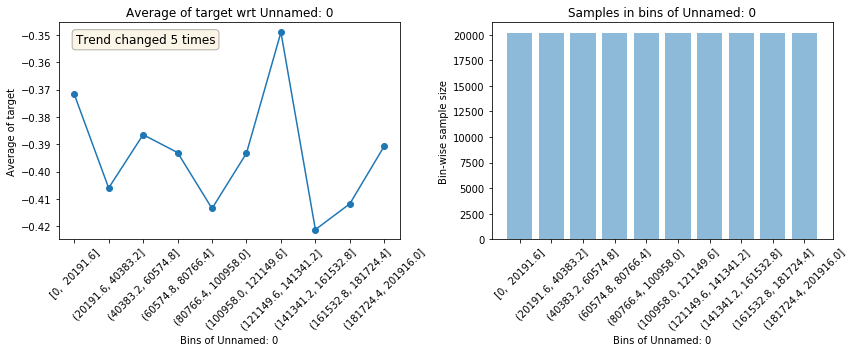

--------------------------------------------------------------------------------------------------------------


                                     Plots for first_active_month                                     


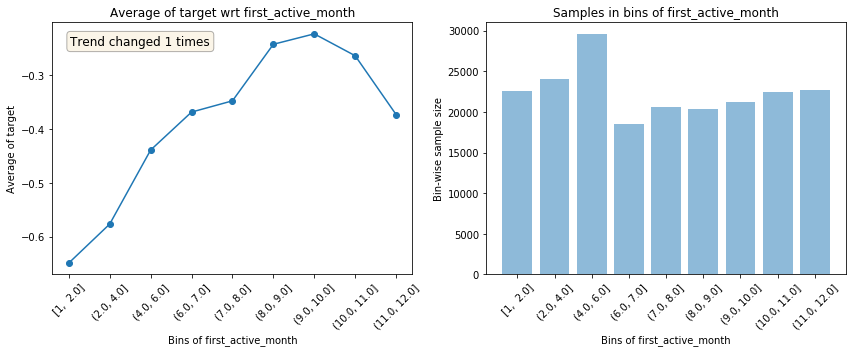

--------------------------------------------------------------------------------------------------------------


                                         Plots for feature_1                                          


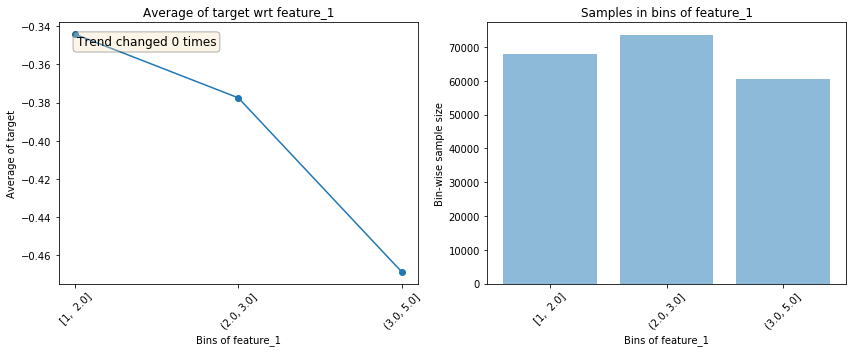

--------------------------------------------------------------------------------------------------------------


                                         Plots for feature_2                                          


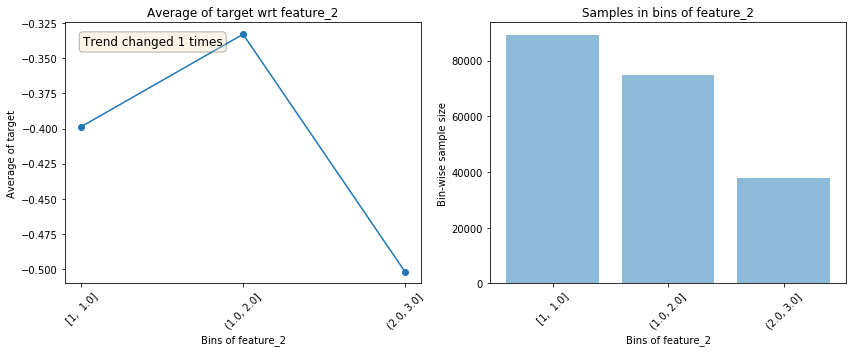

--------------------------------------------------------------------------------------------------------------


                                         Plots for feature_3                                          


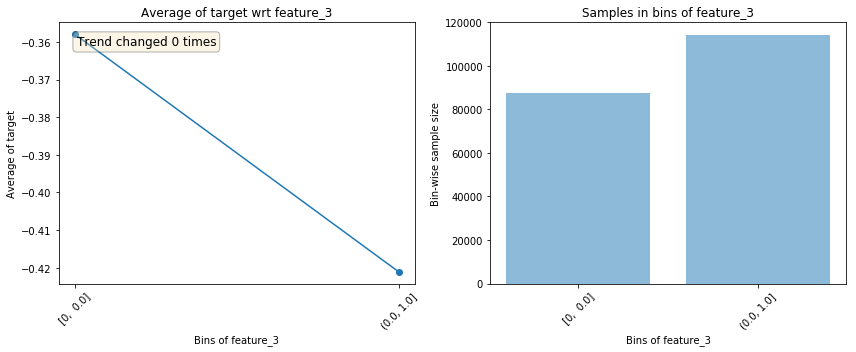

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_transactions_count                                   


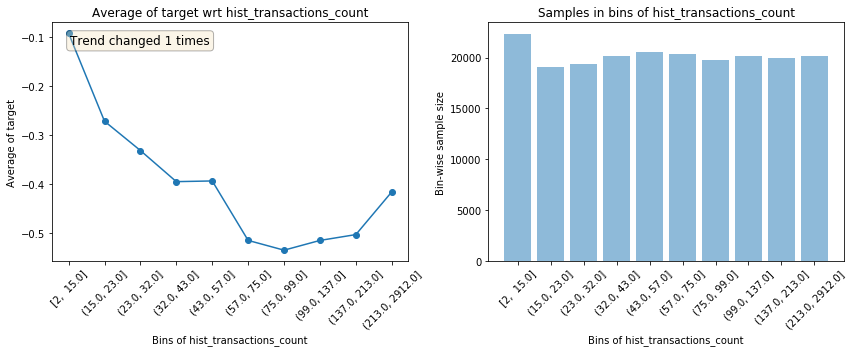

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_category_3_B_mean                                   


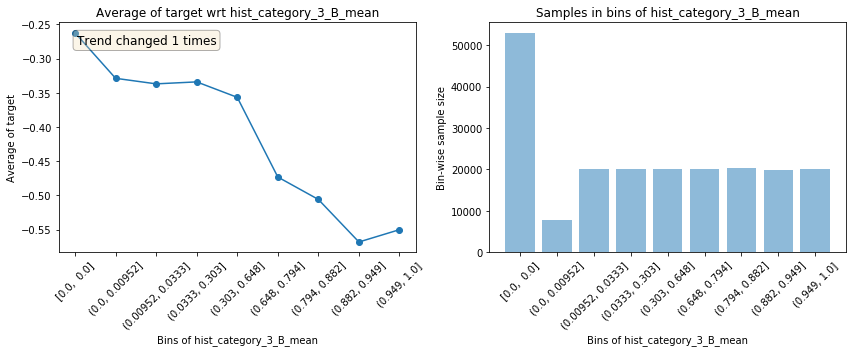

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_category_2_3.0_mean                                  


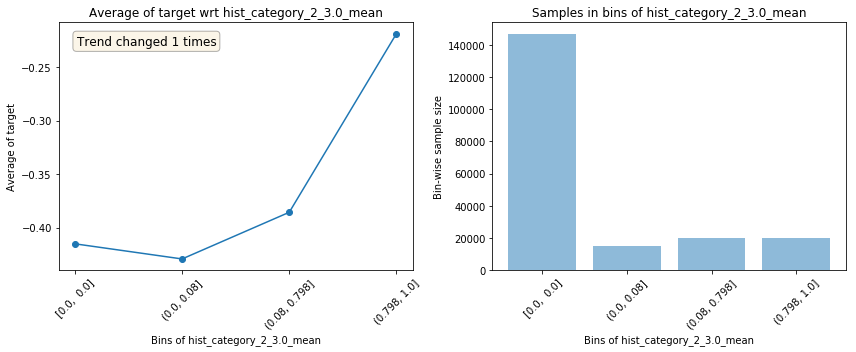

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_sum                                    


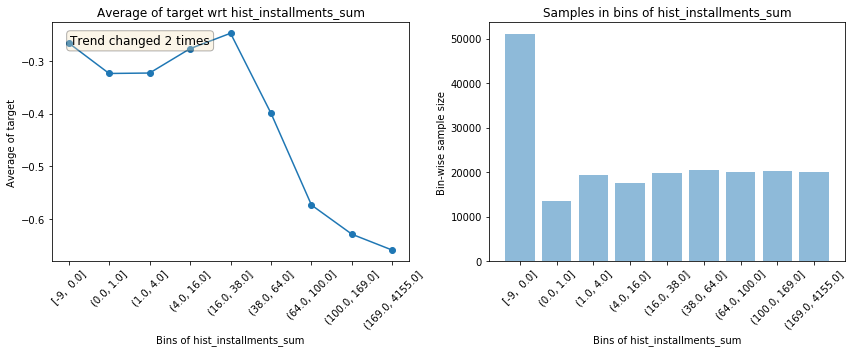

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_mean                                   


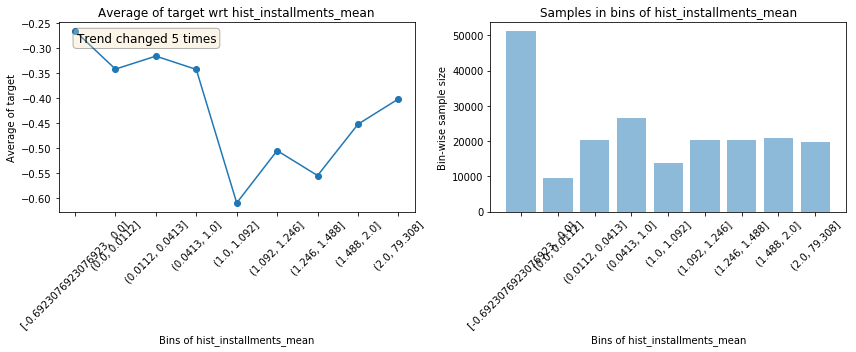

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_max                                    


ValueError: bins must increase monotonically.

In [18]:
get_univariate_plots(data=df_train, target_col='target', bins=10)

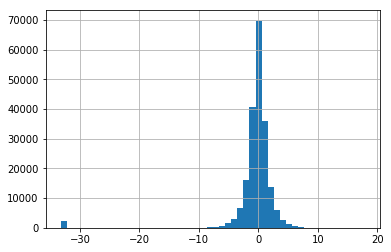

In [7]:
df_train['target'].hist(bins=50)

<h3>Try : Removing least correlated features</h3>

In [12]:
less_correlated_cols = ['new_dim_2_mean',
                         'new_dim_1_mean',
                         'new_category_2_1.0_mean',
                         'hist_category_2_2.0_mean',
                         'new_category_2_2.0_mean',
                         'Unnamed: 0',
                         'hist_month_lag_min',
                         'hist_category_2_4.0_mean',
                         'hist_dim_2_mean',
                         'hist_dim_1_mean',
                         'hist_category_2_1.0_mean',
                         'new_dim_1_std',
                         'new_dim_2_std',
                         'hist_dim_1_std',
                         'hist_dim_2_std',
                         'hist_month_lag_mean',
                         'hist_dim_1_min',
                         'hist_dim_2_min',
                         'hist_category_3_C_mean',
                         'new_category_3_B_mean',
                         'feature_2',
                         'hist_city_id_nunique',
                         'hist_purchase_date_ptp',
                         'hist_category_2_5.0_mean',
                         'feature_3',
                         'hist_dim_1_max',
                         'hist_dim_2_max',
                         'hist_merchant_id_nunique',
                         'new_purchase_amount_sum']

In [28]:
df_train = df_train[['new_category_3_C_mean',
                     'hist_category_1_mean',
                     'new_installments_mean',
                     'hist_purchase_month_min',
                     'new_transactions_count',
                     'hist_installments_min',
                     'first_active_year',
                     'hist_authorized_flag_mean',
                     'new_category_1_sum',
                     'hist_category_1_sum',
                     'new_month_lag_min',
                     'new_month_lag_mean',
                     'hist_purchase_month_max',
                     'new_purchase_amount_max',
                     'hist_purchase_date_min',
                     'new_purchase_month_mean',
                     'hist_purchase_month_std', 'target']]

In [29]:
y = df_train.pop('target')
X = df_train

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

**ML models**

In [30]:
model = Lasso(random_state=42)
param_grid = {'alpha': [0.1, 0.5, 1]}
lasso = evaluate_model(model, param_grid, X_train, X_test, y_train, y_test)

('Best model ==> ', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))
-- Test: Fitting done
-- Test: Prediction done
('TEST RMSE = ', 3.8430823794473468)


In [33]:
model = DecisionTreeRegressor(random_state=42)
param_grid = {'max_features': [3, 5, 10],
              'max_depth': [5, 10, 20]}
dt = evaluate_model(model, param_grid, X_train, X_test, y_train, y_test)

('Best model ==> ', DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=10,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'))
-- Test: Fitting done
-- Test: Prediction done
('TEST RMSE = ', 3.7907972148014784)


In [34]:
model = XGBRegressor(random_state=42)
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10],
              'learning_rate': [0.01, 0.1, 1]}
gb = evaluate_model(model, param_grid, X_train, X_test, y_train, y_test)

('Best model ==> ', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))
-- Test: Fitting done
-- Test: Prediction done
('TEST RMSE = ', 3.7345605567590474)


**Saving best model**

In [35]:
import pickle

In [36]:
filename = DATA_PATH + 'gb_v2.sav'
pickle.dump(gb['model'], open(filename, 'wb'))

**Making predictions**

In [38]:
filename = DATA_PATH + 'gb_v2.sav'
model = pickle.load(open(filename, 'rb'))

In [41]:
df_test = df_test[['new_category_3_C_mean',
                     'hist_category_1_mean',
                     'new_installments_mean',
                     'hist_purchase_month_min',
                     'new_transactions_count',
                     'hist_installments_min',
                     'first_active_year',
                     'hist_authorized_flag_mean',
                     'new_category_1_sum',
                     'hist_category_1_sum',
                     'new_month_lag_min',
                     'new_month_lag_mean',
                     'hist_purchase_month_max',
                     'new_purchase_amount_max',
                     'hist_purchase_date_min',
                     'new_purchase_month_mean',
                     'hist_purchase_month_std']]

In [42]:
predictions = model.predict(df_test)

In [43]:
sub_df = pd.DataFrame({"card_id": df_sample_sub["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv(DATA_PATH +"submit_v3.csv", index=False)

**Model analysis**

In [44]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
(pd.Series(model.feature_importances_, index=df_train.columns.tolist())
  .nlargest(30)
  .plot(kind='barh'))

<h2>Partial dependency plot</h2>

In [34]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence